In [1]:
from __future__ import print_function
import argparse
import numpy as np 
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')


DIM = 2
logCCs = []

# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()
# use_mps = not args.no_mps and torch.backends.mps.is_available()


# torch.manual_seed(args.seed)
torch.manual_seed(1)

# if args.cuda:
#     device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

device = torch.device("cpu")


# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=False)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, DIM)
        self.fc22 = nn.Linear(400, DIM)
        self.fc3 = nn.Linear(DIM, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    # computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    # returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    # [l_lim, u_lim].
    # cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as torch.where evaluates
    # both options, regardless of the value of the condition.
    cut_lam = torch.where(torch.logical_or(torch.less(lam, l_lim), torch.greater(lam, u_lim)), lam, l_lim * torch.ones_like(lam))
    log_norm = torch.log(torch.abs(2.0 * torch.atanh(1 - 2.0 * cut_lam))) - torch.log(torch.abs(1 - 2.0 * cut_lam))
    taylor = np.log(2.0) + 4.0 / 3.0 * torch.pow(lam - 0.5, 2) + 104.0 / 45.0 * torch.pow(lam - 0.5, 4)
    return torch.where(torch.logical_or(torch.less(lam, l_lim), torch.greater(lam, u_lim)), log_norm, taylor)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # print(torch.unique(x))
    # print(torch.unique(recon_x))
    # print(recon_x[0,0].dtype)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') 
    logC = cont_bern_log_norm(recon_x)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    logCC = logC.sum()
    logCCs.append(logCC)
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print(BCE + KLD)
    # if torch.isinf(BCE + KLD + logCC):
    #     print(torch.unique(recon_x)) 
    #     print(torch.unique(logC))
    return BCE + KLD + logCC


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(128, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                           'newresults/reconstruction_' + str(epoch) + '.png', nrow=n)
                # print(mu, logvar)
                # print(mu.shape)
                # print(logvar.shape)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


if __name__ == "__main__":
    for epoch in range(1, 10 + 1):
        a = train(epoch)
        print(a)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, DIM).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'newresults/sample_' + str(epoch) + '.png')


Train Epoch: 1 [0/60000 (0%)]	Loss: 1099.743530
Train Epoch: 1 [1280/60000 (2%)]	Loss: 936.714661
Train Epoch: 1 [2560/60000 (4%)]	Loss: 929.992432
Train Epoch: 1 [3840/60000 (6%)]	Loss: 921.369812
Train Epoch: 1 [5120/60000 (9%)]	Loss: 918.948792
Train Epoch: 1 [6400/60000 (11%)]	Loss: 921.192261
Train Epoch: 1 [7680/60000 (13%)]	Loss: 918.999573
Train Epoch: 1 [8960/60000 (15%)]	Loss: 917.622559
Train Epoch: 1 [10240/60000 (17%)]	Loss: 918.458618
Train Epoch: 1 [11520/60000 (19%)]	Loss: 918.195435
Train Epoch: 1 [12800/60000 (21%)]	Loss: 914.180115
Train Epoch: 1 [14080/60000 (23%)]	Loss: 911.348755
Train Epoch: 1 [15360/60000 (26%)]	Loss: 911.797363
Train Epoch: 1 [16640/60000 (28%)]	Loss: 912.456665
Train Epoch: 1 [17920/60000 (30%)]	Loss: 909.122925
Train Epoch: 1 [19200/60000 (32%)]	Loss: 915.541382
Train Epoch: 1 [20480/60000 (34%)]	Loss: 909.309875
Train Epoch: 1 [21760/60000 (36%)]	Loss: 914.522217
Train Epoch: 1 [23040/60000 (38%)]	Loss: 913.355164
Train Epoch: 1 [24320/60000

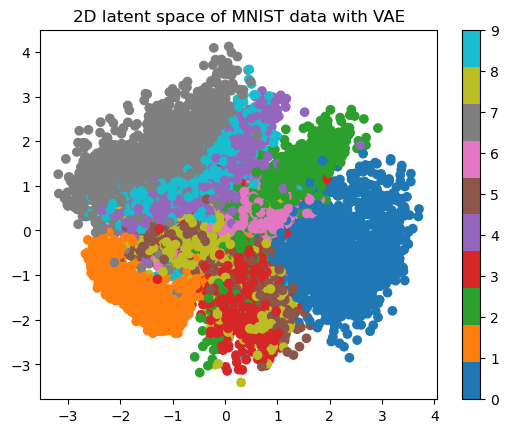

In [2]:
import matplotlib.pyplot as plt 

def plot_latent(model, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        # print(i)
        # print(x.shape)
        # print(y.shape)
        # print(x.to(device).reshape(-1, 784).shape)
        mu, logvar = model.encode(x.view(-1, 784))
        # z = model.reparameterize(mu, logvar).detach().numpy()
        z = mu.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        plt.title("2D latent space of MNIST data with VAE")
        if i > num_batches:
            plt.colorbar()
            break

# print(train_loader)
plot_latent(model, train_loader, 128)

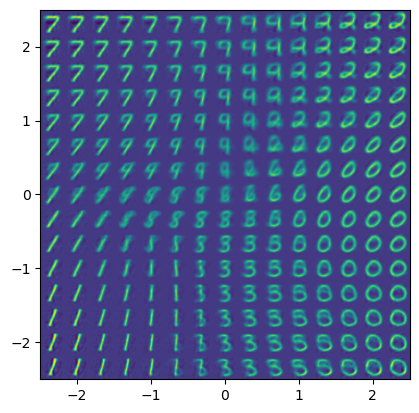

In [3]:
# https://avandekleut.github.io/vae/
def plot_reconstructed(model, r0=(-2.5, 2.5), r1=(-2.5, 2.5), n=15):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decode(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(model)